In [25]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline

# Question

The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder:
the customer who bought the most items overall in her lifetime
for each item, the customer who bought that product the most

Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

# Load Dataset

In [26]:
item_to_id = pd.read_csv('/Users/check4068/Desktop/Product Sense/9.Clustering Grocery Items/item_to_id.csv')
item_to_id

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39
5,dinner rolls,37
6,tortillas,34
7,bagels,13
8,canned vegetables,28
9,spaghetti sauce,26


In [27]:
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [28]:
# Unique ids
print(sorted(item_to_id['Item_id'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [55]:
history = pd.read_csv('/Users/check4068/Desktop/Product Sense/9.Clustering Grocery Items/purchase_history.csv')
history.head()

(39474, 2)

In [30]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [31]:
# Data Processing

In [32]:
# ref: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/09.ClusterGrocery/cluster_grocery.ipynb
def id_to_item(df):
    """ function to convert id into counts """
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

In [59]:
# get user_item count matrix
user_item_count = history.groupby('user_id').apply(id_to_item)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# Question 1

### The customer who bought the most items overall in her lifetime

In [34]:
user_count = user_item_count.sum(axis=1).reset_index().rename(columns={0: 'count'})
user_count.sort_values(by='count', ascending=False).head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


So the customer who bought the most items is 269335 with 72 items

### For each item, the customer who bought that product the most

In [35]:
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most = item_user_most.rename(columns={'index': 'Item_id', 0: 'User_id'})

df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,512
1,2,lettuce,512
2,3,pet items,2552
3,4,baby items,92
4,5,waffles,3605
5,6,poultry,5555
6,7,sandwich bags,2926
7,8,butter,2493
8,9,soda,4445
9,10,carrots,10238


# Question 2

In [36]:
# define the feature matrix: item_id, user_id
feature = user_item_count.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [37]:
# determine the best number of clusters
clusters = range(2, 30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_jobs=-1)
    kmeans = kmeans.fit(feature)
    label = kmeans.predict(feature)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature, label))

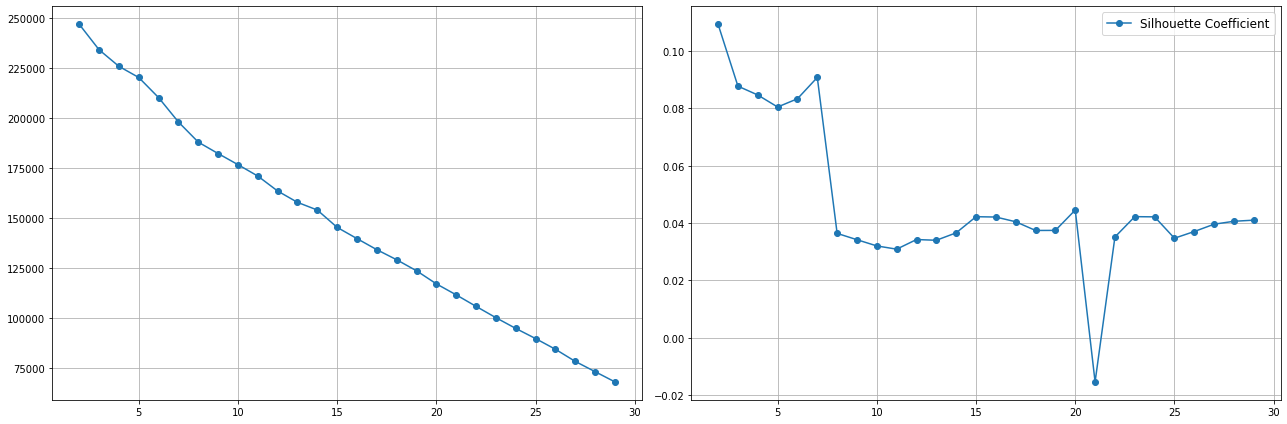

In [38]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

It seems 21 clusters is the best choice. Now, let's apply PCA on the data and visualize the data.

In [39]:
# build K-Means model
kmeans = KMeans(n_clusters=21, init='k-means++', random_state=42, n_jobs=-1)
kmeans = kmeans.fit(feature)
label = kmeans.predict(feature)

In [40]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

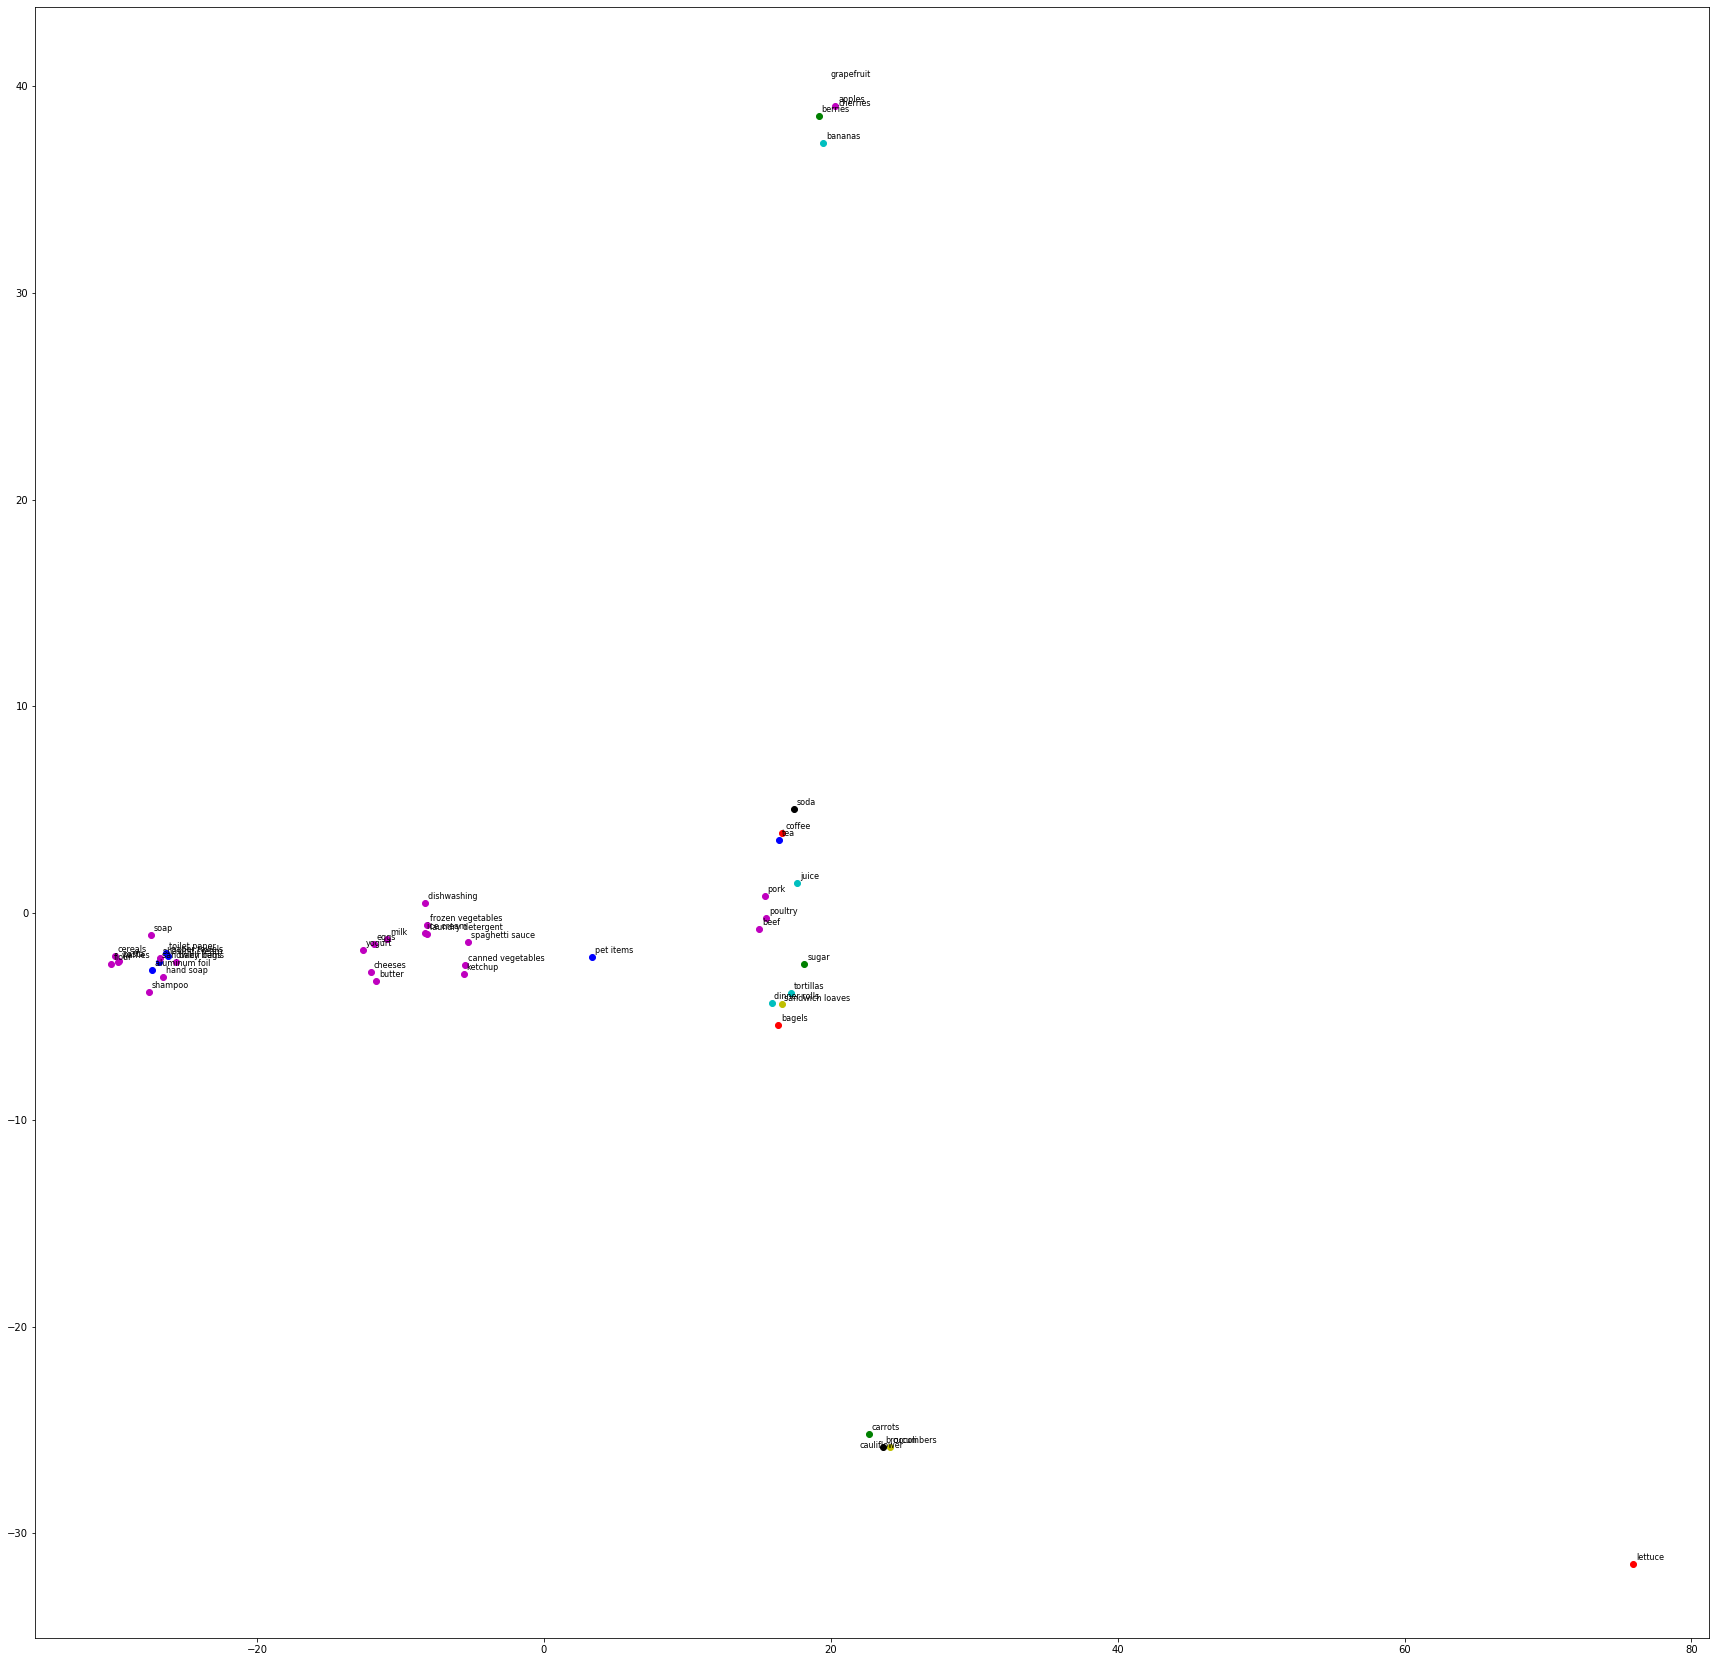

In [44]:
# visualization in 2D
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(30, 30))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=8)

plt.show()

In [42]:
# print useful information
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 21):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['sandwich bags', 'aluminum foil', 'paper towels', 'toilet paper']
1 	 ['sugar']
2 	 ['bagels']
3 	 ['juice']
4 	 ['baby items', 'waffles', 'butter', 'cereals', 'shampoo', 'eggs', 'milk', 'laundry detergent', 'shaving cream', 'cheeses', 'frozen vegetables', 'spaghetti sauce', 'dishwashing\xa0', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'soap', 'ice cream', 'ketchup', 'yogurt']
5 	 ['cucumbers']
6 	 ['broccoli']
7 	 ['cauliflower']
8 	 ['tea']
9 	 ['berries']
10 	 ['lettuce']
11 	 ['bananas']
12 	 ['poultry', 'beef', 'pork']
13 	 ['sandwich loaves']
14 	 ['soda']
15 	 ['grapefruit', 'cherries']
16 	 ['pet items']
17 	 ['carrots']
18 	 ['coffee']
19 	 ['tortillas', 'dinner rolls']
20 	 ['apples']


Above clustering is based on the raw feature, namely the user purchase for each item. There are other methods for this problem. For example, this notebook contains another method: [notebook link](https://github.com/stasi009/TakeHomeDataChallenges/blob/master/09.ClusterGrocery/cluster_grocery.ipynb).

With 21 clusters, some cluster looks very weird. Since there are only 48 different items, with one business expert in related area, it only take a few time to manually determine the best cluster numbers.